# Lesson 2 - Calculating the Average Clutter Height using LiDAR

In this lesson you will determine the average height of the clutter of the Martin Acres neighborhood in the city of Boulder, Colorado. 

<img src="./images/martin_acres_labeled.png" alt="Martin Acres Map" width="800"/>

The image shows a map of Boulder, Colorado with Martin Acres circled. Martin Acres is a residential neighborhood containing mostly single family homes. You will use LiDAR data to determine the average height of the clutter (buildings and trees) in this region. 

The following cell will import the needed python libraries.

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

### LiDAR Data Files

The LiDAR data for this tutorial is in the `course-materials/data/` directory. 

- **`course-materials/data/MartinAcres.dtm.tif`**
- **`course-materials/data/MartinAcres.dsm.tif`**

For Martin Acres there are two .tif files: a Digital Surface Model (DSM), and a Digital Terrain Model (DTM). The DSM contains the elevation of the tallest points in the area, which is often the tops of trees and buildings. The DTM contains the the elevation of the ground. 

<img src="./images/DSM_DTMcropped.png" alt="DSM DTM" width="500"/>

Image from ["What is a CHM, DSM and DTM? About Gridded, Raster LiDAR Data" by Leah A. Wasser](https://www.neonscience.org/resources/learning-hub/tutorials/chm-dsm-dtm).

The following cell opens and reads the DTM and DSM files. It also sets variables with the boundry coordinates of the .tif files.

In [2]:
## get Digital Terrain Model
dataset_terrain = rasterio.open("./data/MartinAcres.dtm.tif")
## get Digital Surface Model
dataset_surface = rasterio.open("./data/MartinAcres.dsm.tif")

## read the elevation layer
band1_terrain = dataset_terrain.read(1)
band1_surface = dataset_surface.read(1)

## dataset_terrain and dataset_surface uses EPSG:32613 coordinate system, unit is in meters
## print the bounds of the dataset
print("The bounds of the LiDAR dataset. In meters:\n ", dataset_terrain.bounds) 

## LiDAR boundries in meters (EPSG:32613)
left, bottom, right, top = dataset_terrain.bounds

## LiDAR boundries in Lat, Long coordinates
## EPSG 32613 converted to EPSG:4326 (used in GPS) with https://epsg.io/transform#s_srs=32613&t_srs=4326&x=NaN&y=NaN
left_deg, bottom_deg, right_deg, top_deg = (-105.2869255, 39.9747967, -105.2343079, 40.0019534)
print("The bounds of the LiDAR dataset. In lat/long coordinates:\n ", left_deg, bottom_deg, right_deg, top_deg) 

## For converting lat and long degrees into meters (only used in small distances)
meters_per_lat = 111319.49 
meters_per_long = 85263.24 ## only valid at latitudes of 40 degrees

The bounds of the LiDAR dataset. In meters:
  BoundingBox(left=475499.11, bottom=4424999.32, right=480000.11, top=4428000.32)
The bounds of the LiDAR dataset. In lat/long coordinates:
  -105.2869255 39.9747967 -105.2343079 40.0019534


### Visualize MartinAcres.dtm.tif and MartinAcres.dsm.tif

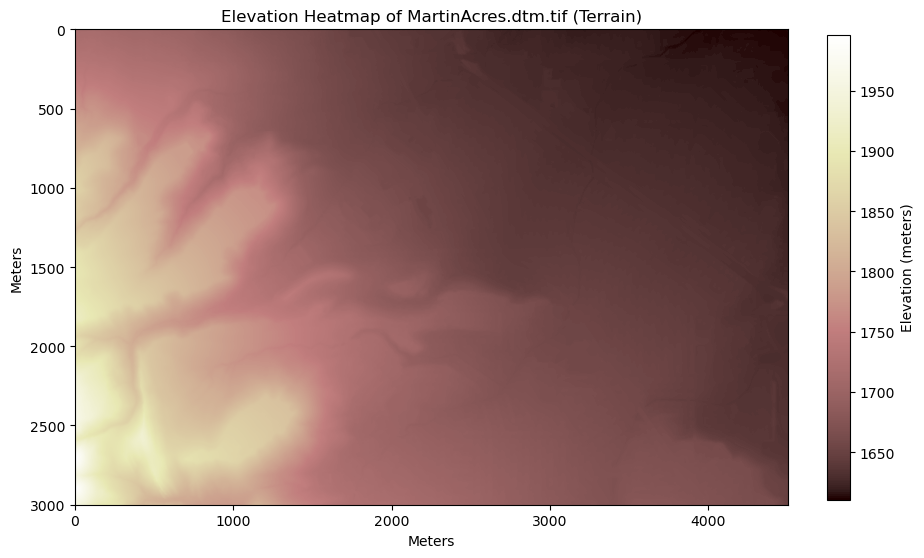

In [3]:
plt.figure(figsize=(10,10))
plt.title("Elevation Heatmap of MartinAcres.dtm.tif (Terrain)")
plt.xlabel("Meters")
plt.ylabel("Meters")
dtm_plt = plt.imshow(band1_terrain, cmap='pink')
cbar = plt.colorbar(dtm_plt, fraction=0.03)
cbar.set_label('Elevation (meters)')
plt.show()

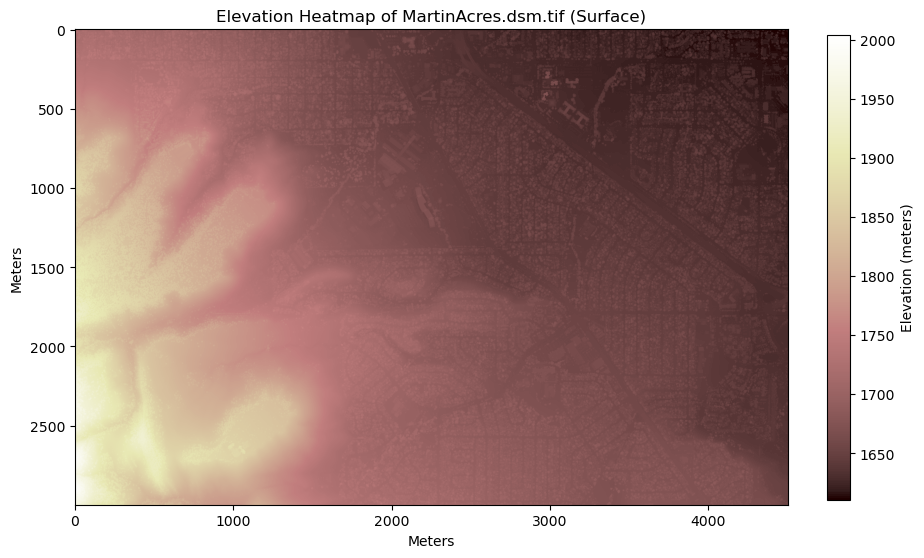

In [4]:
plt.figure(figsize=(10,10))
plt.title("Elevation Heatmap of MartinAcres.dsm.tif (Surface)")
plt.xlabel("Meters")
plt.ylabel("Meters")
dtm_plt = plt.imshow(band1_surface, cmap='pink')
cbar = plt.colorbar(dtm_plt, fraction=0.03)
cbar.set_label('Elevation (meters)')
plt.show()

### Find the _Ground_ and _Clutter_ elevation at the center of Martin Acres

The get_elev function takes a latitude and longitude input and returns the elevation of the ground or clutter.


__Martin Acres center__: <br/>
Latitude = 39.9916 <br/>
Longitude = -105.2510

In [ ]:
## takes a lat, long coordinate pair
##  and returns a meters based coordinate pair
def convert_gps_to_meters(lat, long):
    lat_dif = top_deg - lat
    long_dif = long - left_deg
    vert_dif_m = lat_dif * meters_per_lat
    horz_dif_m = long_dif * meters_per_long
    return (vert_dif_m, horz_dif_m)

## get_elev function finds the elevation of a Latitude and Longitude location 
##  takes lat and long of the location, lidar dataset (DSM or DTM), and the lidar band that holds elevation
def get_elev(lat, long, lidar_model, lidar_elev_band):
    vert_dif_m, horz_dif_m = convert_gps_to_meters(lat, long)
    row, col = lidar_model.index(left + horz_dif_m, top - vert_dif_m) ## get the row and colomn where the elevation is stored
    elev = lidar_elev_band[row][col] ## retrieve the elevation
    return elev

## set Martin Acres center location
ma_center = (39.9916, -105.2510)
print("Martin Acres center {}:".format(ma_center))

## find the terrain elevation
terrain_elev = get_elev(ma_center[0], ma_center[1], dataset_terrain, band1_terrain)
print("The ground elevation is {:.1f} meters".format(terrain_elev))

## find the surface elevation
surface_elev = get_elev(ma_center[0], ma_center[1], dataset_surface, band1_surface)
print("The clutter elevation is {:.1f} meters".format(surface_elev))

### Plot Martin Acres Center on a Map

In [ ]:
## convert example location from lat/long to meters
ma_center_meters = convert_gps_to_meters(ma_center[0], ma_center[1])

## read in Martin Acres map image
##  image from www.openstreetmap.org
martin_acres_map = plt.imread('./images/martin_acres_map.png')

## set the map bounding box (in meters)
BBox = (0,  right-left,      
        top-bottom,  0)

## plot the map with plt.imshow() and plot the point with plt.scatter().
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()
plt.title('Plot Martin Acres Center Location')
plt.xlabel("Meters")
plt.ylabel("Meters")
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(martin_acres_map, zorder=0, extent = BBox, aspect= 'equal')
plt.scatter(ma_center_meters[1], ma_center_meters[0], label="Martin Acres Center")
plt.legend()
plt.show()

### Take Clutter Height Samples

In [ ]:
print("Example Point is at x = {:.2f}, y = {:.2f} (in meters). The origin is the top left corner of the map.".format(ma_center[1], ma_center[0]))

In [ ]:
## generate 1000 random x,y locations near the Martin Acres center
x_random = np.random.randint(2572, 3572, 1000)
y_random = np.random.randint(639, 1639, 1000)

## create lists to hold the locations and clutter heights that are within 500 meters of the Example Point
within_500m_x = []
within_500m_y = []
clutter_height_ls = []

## loop through all of the random points
for i in range(len(x_random)):
    ## find distance from Example Point to a random point
    distance = np.sqrt(np.square(ma_center_meters[1]-x_random[i]) + np.square(ma_center_meters[0]-y_random[i]))
    
    ## if distance is within 500 meters, find the clutter height at that location
    if distance < 500:
        ground_elev = band1_terrain[y_random[i]][x_random[i]]
        clutter_elev = band1_surface[y_random[i]][x_random[i]]
        clutter_height = clutter_elev - ground_elev
        ## clutter must be higher than 2 meters to be considered "clutter"
        if clutter_height > 2:
            clutter_height_ls.append(clutter_height)
            within_500m_x.append(x_random[i])
            within_500m_y.append(y_random[i])


## plotting
plt.rcParams["figure.figsize"] = (10,10)

ex1 = plt.scatter(within_500m_x, within_500m_y, zorder=1, c=clutter_height_ls, cmap='cool', alpha= 1.0, s=25)
cbar = plt.colorbar(ex1, fraction=0.03)
cbar.set_label('Clutter Height (meters)')

plt.title('Randomly Sampled Clutter Heights\n within 500 meters of the center')
plt.xlabel("Meters")
plt.ylabel("Meters")
plt.xlim(BBox[0],BBox[1])
plt.ylim(BBox[2],BBox[3])
plt.imshow(martin_acres_map, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

### Do Clutter Height Sampling With A Lot More Random Locations (~500,000 Samples)

Same code as previous cell, starting with 1 million random locations before narrowing down to points:
  * Within 500 meters of Martin Acres center.
  * Having at least 2 meters of clutter height.

In [ ]:
num_rands = 1000000

## generate random x,y locations
x_random = np.random.randint(2572, 3572, num_rands)
y_random = np.random.randint(639, 1639, num_rands)

## create lists to hold the locations and clutter heights that are within 500 meters of the center
within_500m_x = []
within_500m_y = []
clutter_height_ls = []

## loop through all of the random points
for i in range(len(x_random)):
    ## print the progress
    if i % 10000 == 0:
        print("\rProgress {}/{}".format(i,num_rands), end='')
        
    ## find distance from Example Point to a random point
    distance = np.sqrt(np.square(ma_center_meters[1]-x_random[i]) + np.square(ma_center_meters[0]-y_random[i]))
    
    ## if distance is within 500 meters, find the clutter height at that location
    if distance < 500:
        ground_elev = band1_terrain[y_random[i]][x_random[i]]
        clutter_elev = band1_surface[y_random[i]][x_random[i]]
        clutter_height = clutter_elev - ground_elev

        ## clutter must be higher than 2 meters to be considered "clutter"
        if clutter_height > 2:
            clutter_height_ls.append(clutter_height)
            within_500m_x.append(x_random[i])
            within_500m_y.append(y_random[i])

print()
print("{} successful clutter samples".format(len(clutter_height_ls)))

### Plot a Histogram of the Clutter Heights Sampled in Martin Acres

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)

# the histogram of the data
n, bins, patches = plt.hist(clutter_height_ls, np.linspace(2,35,34), density=True, facecolor='g', alpha=.85)


plt.xlabel('Clutter Height (meters)')
plt.ylabel('Probability')
plt.title('Histogram of Clutter Heights of Martin Acres')
plt.grid(True)
plt.show()

The most commom height clutter height in Martin Acres is between 3 to 5 meters. Print the mean, median, and standard deviation of the Martin Acres clutter.

In [ ]:
print("Martin Acres Clutter Heights:\n Mean = {:.1f} meters\n Median = {:.1f} meters\n Standard Deviation = {:.1f} meters".format(np.mean(clutter_height_ls),
                                                                                                                         np.median(clutter_height_ls),
                                                                                                                         np.std(clutter_height_ls)))

Well done, you've found the clutter statistics for the Martin Acres neighborhood using LiDAR data. In the next lesson you'll use these statistics to inform a clutter model.

End of Lesson 2.